# SHAP for Neural Network Models

## **1. Introduction**

SHAP is model-agnostic and can be used to explain other black box models as well, for example, neural networks.
The shap module in python has something called KernelExplainer which can be used for NNs.

Let's illustrate this using a [Credit Card Defaulter dataset from Taiwan](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

The dataset has the following 23 variables as explanatory variables:
| Variable | Description |
|----------|------------|
| LIMIT_BAL  | Amount of the given credit (NT dollar): includes both individual consumer credit and family (supplementary) credit. |
| SEX  | Gender (1 = male; 2 = female). |
| EDUCATION  | Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). |
| MARRIAGE  | Marital status (1 = married; 2 = single; 3 = others). |
| AGE  | Age (years). |
| PAY_0  | Repayment status in September 2005 (-1 = pay duly; 1 = delay for 1 month; 2 = delay for 2 months; ...; 8 = delay for 8 months; 9 = delay for 9+ months). |
|  PAY_2 | Repayment status in August 2005. |
| PAY_3  | Repayment status in July 2005. |
| PAY_4  | Repayment status in June 2005. |
| PAY_5 | Repayment status in May 2005. |
| PAY_6 | Repayment status in April 2005. |
| BILL_AMT1 | Amount of bill statement (NT dollar) in September 2005. |
| BILL_AMT2 | Amount of bill statement (NT dollar) in August 2005. |
| BILL_AMT3 | Amount of bill statement (NT dollar) in July 2005. |
| BILL_AMT4 | Amount of bill statement (NT dollar) in June 2005. |
| BILL_AMT5 | Amount of bill statement (NT dollar) in May 2005. |
| BILL_AMT6 | Amount of bill statement (NT dollar) in April 2005. |
| PAY_AMT1 | Amount of previous payment (NT dollar) in September 2005. |
| PAY_AMT2 | Amount of previous payment (NT dollar) in August 2005. |
| PAY_AMT3 | Amount of previous payment (NT dollar) in July 2005. |
| PAY_AMT4 | Amount of previous payment (NT dollar) in June 2005. |
| PAY_AMT5 | Amount of previous payment (NT dollar) in May 2005. |
| PAY_AMT6 | Amount of previous payment (NT dollar) in April 2005. |

## **2. Import the necessary libraries**

In [12]:
# Note: pip install xlrd to read excel files in pandas

import shap
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from torch.utils.data import Dataset, DataLoader

np.random.seed(1)

## **3. Loading the dataset**

In [13]:
# Load the data
data = pd.read_excel(
    "../datasets/credit-card-defaulters-taiwan/default of credit card clients.xls",
    header=1,
)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## **4. Create a PyTorch dataset**
Create a dataset class inherited from PyTorch Dataset to be input for model training.

In [14]:
# Load dataset
X = data.drop(["default payment next month", "ID"], axis=1)
y = data["default payment next month"]

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
y_train = y_train.values  # Convert pandas series to NumPy array
y_test = y_test.values


# Create a PyTorch Dataset
class CreditDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(
            -1, 1
        )  # Reshape y to be column vector

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Create DataLoaders for batching
batch_size = 64
train_dataset = CreditDataset(X_train, y_train)
test_dataset = CreditDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **5. Train a 3-layer MLP using PyTorch**
Let's train a simple 3-layer MLP to predict credit card defaults.

Epoch [10/125], Loss: 0.4291
Epoch [20/125], Loss: 0.4224
Epoch [30/125], Loss: 0.4185
Epoch [40/125], Loss: 0.4128
Epoch [50/125], Loss: 0.4104
Epoch [60/125], Loss: 0.4077
Epoch [70/125], Loss: 0.4068
Epoch [80/125], Loss: 0.4027
Epoch [90/125], Loss: 0.4022
Epoch [100/125], Loss: 0.3974
Epoch [110/125], Loss: 0.3971
Epoch [120/125], Loss: 0.3948
Accuracy: 0.8122
ROC AUC Score: 0.7592


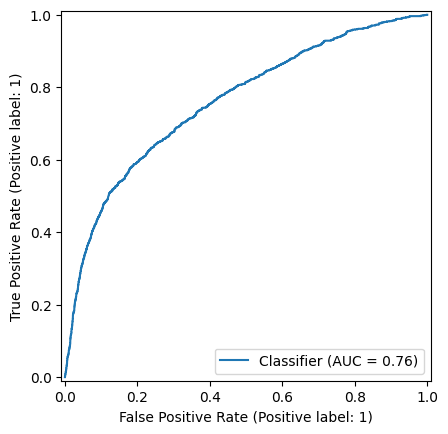

In [15]:
# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model in batches
num_epochs = 125
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print average loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Evaluate the model
model.eval()  # Set model to evaluation mode
y_pred_probs = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        y_pred_probs.extend(outputs.numpy())  # Store predictions
        y_true.extend(batch_y.numpy())  # Store true labels

# Convert predictions to NumPy array
y_pred_probs = np.array(y_pred_probs).flatten()
y_true = np.array(y_true).flatten()

# Compute accuracy
accuracy = ((y_pred_probs > 0.5) == y_true).mean()
print(f"Accuracy: {accuracy:.4f}")

# Compute ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(y_true, y_pred_probs)

## **6. Use SHAP to explain Neural network predictions**

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/50 [00:00<?, ?it/s]

X_test_sample shape: (50, 23)
SHAP values shape: (50, 23, 1)
Updated SHAP values shape: (50, 23)


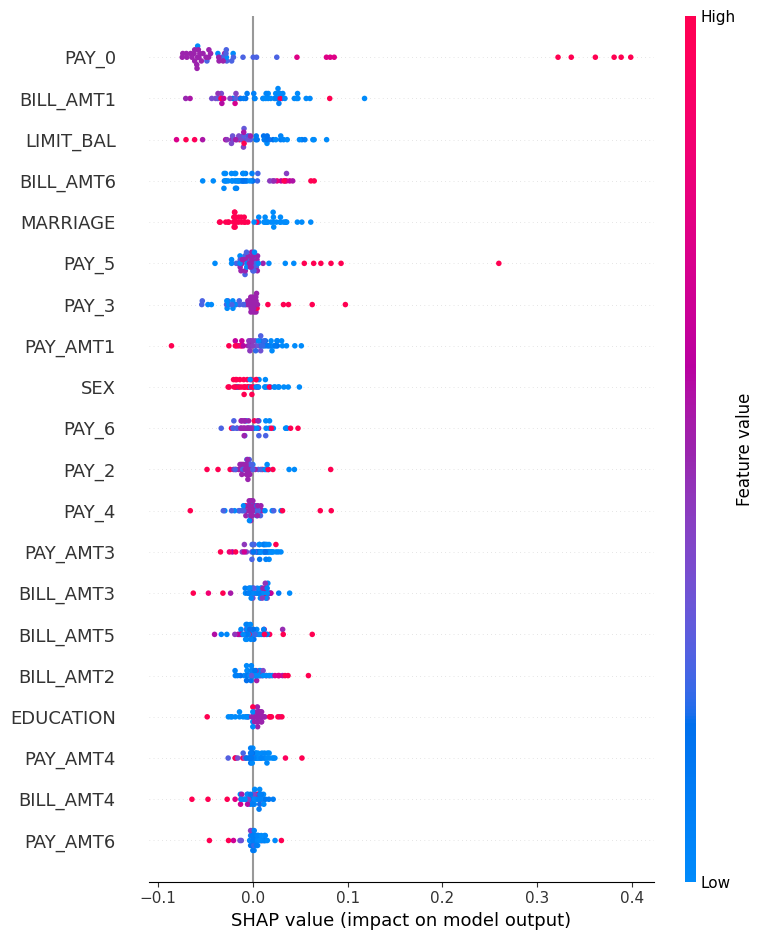

In [16]:
# Use existing NumPy arrays
X_train_np = X_train
X_test_np = X_test

# Reduce background dataset for SHAP (using 200 samples instead of full training set)
background = shap.kmeans(X_train_np, 200)


# Wrapper function for PyTorch model inference
def model_wrapper(data):
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)
        preds = model(data_tensor).detach().numpy()
        # print("Model predictions shape:", preds.shape)  # Should be (n_samples, n_classes)
        return preds


# Use KernelExplainer with reduced background
explainer = shap.KernelExplainer(model_wrapper, background)

# Explain only a small subset of the test set (e.g., 50 samples)
X_test_sample = X_test_np[:50]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

print("X_test_sample shape:", X_test_sample.shape)  # Should be (n_samples, n_features)
print(
    "SHAP values shape:", np.array(shap_values).shape
)  # Should match (n_samples, n_features)

# Remove extra dimension if shap_values is (50, 23, 1)
shap_values = np.array(shap_values)  # Convert to NumPy array
if shap_values.shape[-1] == 1:
    shap_values = shap_values.squeeze(-1)  # Remove last dimension

# Ensure correct shape
print("Updated SHAP values shape:", shap_values.shape)  # Should be (50, 23)


# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test_sample, feature_names=data.columns[1:-1])

1. **What Do the Axes Mean?**
	-	Y-axis (Feature Names): Lists the most important features from top to bottom, ranked by their impact on the model’s predictions.

	-	X-axis (SHAP Value): Represents the impact of each feature on the model’s prediction.

	-	A positive SHAP value increases the probability of default.

	-	A negative SHAP value decreases the probability of default.

2. **What Do the Colors Mean?**
   
	-	Red: High feature value (e.g., high credit limit, high bill amount, etc.)

	-	Blue: Low feature value (e.g., low credit limit, low bill amount, etc.)

	-	Purple: Intermediate values.

    - If a red dot is positioned to the right, it means that a higher value of that feature increases the default risk. If it’s on the left, it decreases the risk.

3. The top-ranked features contribute the most to the model’s prediction. In this case:

	-	**PAY_0 (Repayment Status for the Most Recent Month):**
		- The most significant predictor of default.
		- Higher values (more delayed payments) strongly increase default probability (red dots shift to the right).
	 	-  Lower values (on-time payments) reduce the risk (blue dots shift left).
  
	-	**LIMIT_BAL (Credit Limit Amount):**
		- Higher credit limits seem to reduce the risk of default (red dots slightly shift left).
		-	Lower credit limits are more associated with default risk.

	-	**BILL_AMT4, BILL_AMT1, BILL_AMT6 (Bill Amounts for Different Months):**
		-	Large bill amounts have mixed impact, depending on other factors.
		-	Higher bills (red) sometimes increase default risk but not always.

	-	**PAY_4, PAY_3, PAY_2, PAY_5, PAY_6 (Previous Payment Statuses):**
		-	Late payments from earlier months also contribute to default risk.
		-	Pattern: More delays → Higher SHAP values → More risk.

4. Lesser Impact Features
   
	-	**SEX, AGE, MARRIAGE, EDUCATION:**
		-	These have much lower SHAP values, meaning they don’t significantly influence predictions.
		-	Some impact exists, but it’s much weaker than repayment history.